In [62]:
import pandas as pd

# Load the dataset we generated
df = pd.read_csv("data/tasks.csv")

# Quick look at the first few rows
df.head()

,task_id,task_length_minutes,priority,category,due_in_days,reminders_set,past_completion_rate,is_weekend,day_of_week,dead_urgency,user_busy_level,completed
0,1,107,low,personal,6,1,0.65,1,1,medium,medium,1
1,2,97,low,study,4,1,0.20,0,0,low,high,1
2,3,19,high,health,9,0,0.26,1,2,medium,low,1
3,4,111,low,personal,13,1,0.91,1,6,low,medium,0
4,5,76,high,health,13,0,0.26,1,1,medium,high,0


## Inspecting dataset

In [63]:
print(df.shape)

(2000, 12)


In [64]:
# Check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   task_id               2000 non-null   int64  
 1   task_length_minutes   2000 non-null   int64  
 2   priority              2000 non-null   object 
 3   category              2000 non-null   object 
 4   due_in_days           2000 non-null   int64  
 5   reminders_set         2000 non-null   int64  
 6   past_completion_rate  2000 non-null   float64
 7   is_weekend            2000 non-null   int64  
 8   day_of_week           2000 non-null   int64  
 9   dead_urgency          2000 non-null   object 
 10  user_busy_level       2000 non-null   object 
 11  completed             2000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 187.6+ KB


In [65]:
# Statistics for numerical columns
df.describe()

,task_id,task_length_minutes,due_in_days,reminders_set,past_completion_rate,is_weekend,day_of_week,completed
count,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,91.35850,6.435500,0.500500,0.590045,0.513500,3.019500,0.548000
std,577.494589,50.86046,4.014586,0.500125,0.229089,0.499943,2.013243,0.497815
min,1.000000,5.00000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000
25%,500.750000,47.00000,3.000000,0.000000,0.390000,0.000000,1.000000,0.000000
50%,1000.500000,93.00000,6.000000,1.000000,0.580000,1.000000,3.000000,1.000000
75%,1500.250000,135.00000,10.000000,1.000000,0.780000,1.000000,5.000000,1.000000
max,2000.000000,179.00000,13.000000,1.000000,1.000000,1.000000,6.000000,1.000000


In [66]:
print(df.shape[1])
df.columns

12


Index(['task_id', 'task_length_minutes', 'priority', 'category', 'due_in_days',
       'reminders_set', 'past_completion_rate', 'is_weekend', 'day_of_week',
       'dead_urgency', 'user_busy_level', 'completed'],
      dtype='object')

In [67]:
# Check the target balance
df['completed'].value_counts(normalize=True)

completed
1    0.548
0    0.452
Name: proportion, dtype: float64

## Data Visualization

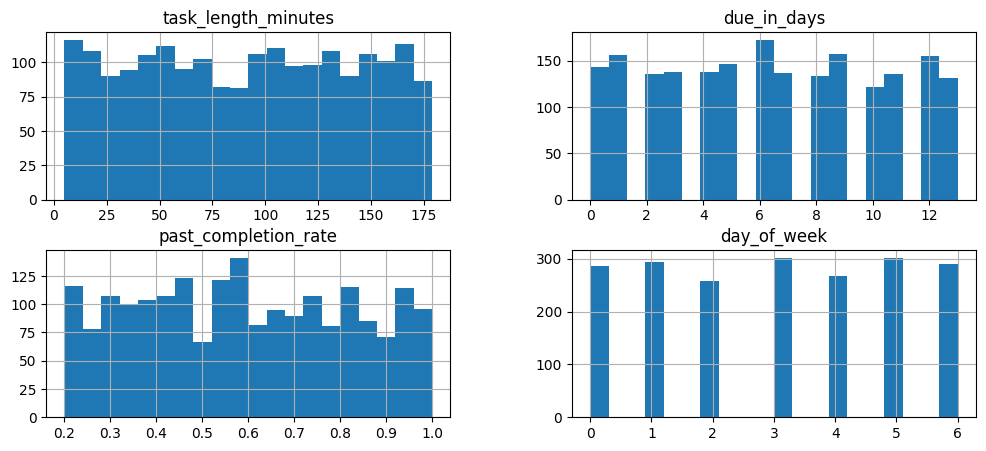

In [68]:
## Numeric Features

import matplotlib.pyplot as plt

numeric_cols = ["task_length_minutes", "due_in_days", "past_completion_rate", "day_of_week"]

df[numeric_cols].hist(bins=20, figsize=(12,5))
plt.show()


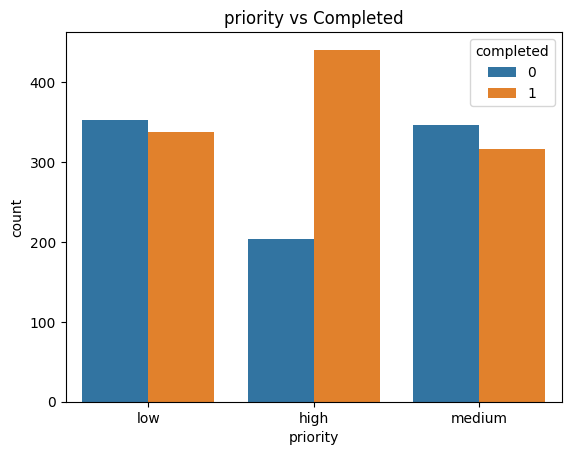

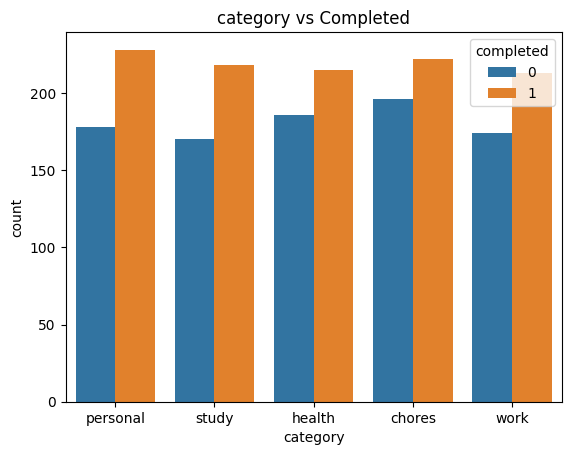

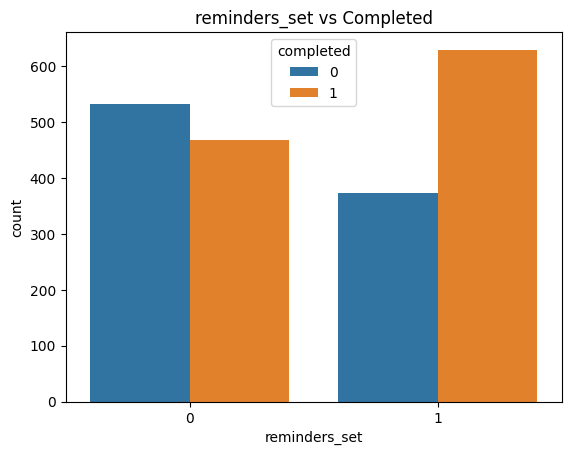

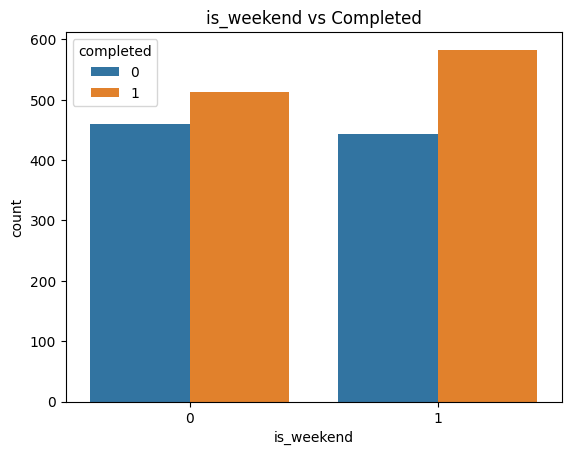

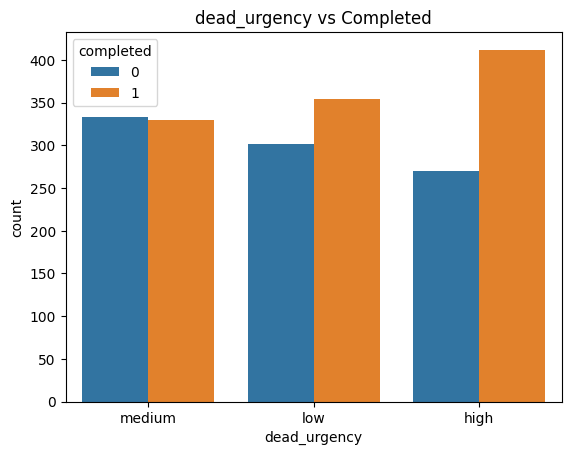

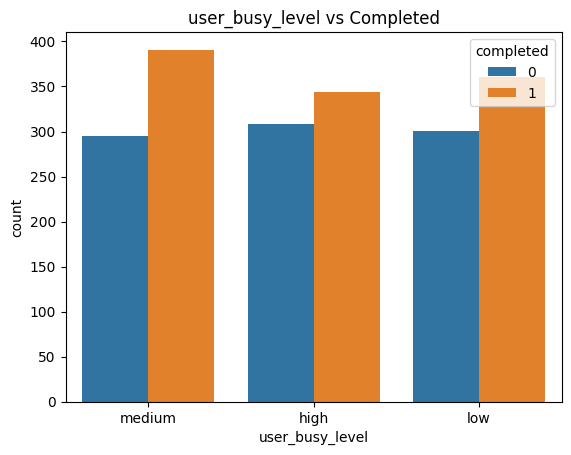

In [69]:
## Categorical features

import seaborn as sns

cat_cols = ["priority", "category", "reminders_set", "is_weekend", "dead_urgency", "user_busy_level"]

for col in cat_cols:
    sns.countplot(data=df, x=col, hue="completed")
    plt.title(f"{col} vs Completed")
    plt.show()


## Prepare data for modeling 

In [70]:
X = df.drop(["completed", "task_id"], axis=1)  # features
y = df["completed"]                             # target


## Data Splicing

In [71]:
from sklearn.model_selection import train_test_split

# STEP 1: split into 60% train and 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# STEP 2: split the 40% temp into 20% val and 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [72]:
## Handle categorical features (One-Hot Encoding)

In [85]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_cols = ["priority", "category", "dead_urgency", "user_busy_level"]
num_cols = ["task_length_minutes", "due_in_days", "reminders_set", "past_completion_rate", "is_weekend", "day_of_week"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")

# Fit on training data ONLY
X_train_encoded = preprocessor.fit_transform(X_train)

# apply transformation to validation and test
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded  = preprocessor.transform(X_test)

In [74]:
# FIX ORDINAL COLUMNS
ordinal_map = {
    "low": 1,
    "medium": 2,
    "high": 3
}

df["priority"] = df["priority"].map(ordinal_map)
df["dead_urgency"] = df["dead_urgency"].map(ordinal_map)
df["user_busy_level"] = df["user_busy_level"].map(ordinal_map)

# FIX NOMINAL COLUMN
df = pd.get_dummies(df, columns=["category"], drop_first=True)

## Train Logistic Regression (Baseline Model)

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create the model with recommended settings
model_lr = LogisticRegression(
    solver='liblinear',
    C=1.0,
    max_iter=1000,
    random_state=42
)

# Train the model
model_lr.fit(X_train_encoded, y_train)

# Predict on validation set
y_val_pred = model_lr.predict(X_val_encoded)

# Calculate accuracy
logreg_accuracy = accuracy_score(y_val, y_val_pred)

# Show accuracy (rounded)
round(logreg_accuracy, 3)

0.657

## Decision Tree Classifier (Baseline Tree Model)

In [77]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training set
dt_model.fit(X_train_encoded, y_train)

# Predict on the validation set
y_pred_dt = dt_model.predict(X_val_encoded)

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dt_accuracy  = accuracy_score(y_val, y_pred_dt)
dt_precision = precision_score(y_val, y_pred_dt)
dt_recall    = recall_score(y_val, y_pred_dt)
dt_f1        = f1_score(y_val, y_pred_dt)

print("Decision Tree Performance on Validation Set")
print("Accuracy :", dt_accuracy)
print("Precision:", dt_precision)
print("Recall   :", dt_recall)
print("F1-score :", dt_f1)


Decision Tree Performance on Validation Set
Accuracy : 0.505
Precision: 0.5416666666666666
Recall   : 0.5416666666666666
F1-score : 0.5416666666666666


## Decision Tree Feature Importance (Bar Chart)

#### Get feature names from the preprocessor

In [87]:
# Confirm how many features the model actually saw

X_train_encoded.shape

(1200, 20)

In [90]:
# Get categorical feature names from OneHotEncoder
cat_feature_names = (
    preprocessor.named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
    .tolist()
)

# Combine categorical + numerical
all_feature_names = cat_feature_names + num_cols

In [89]:
print(X_train_encoded.shape[1])
print(len(all_feature_names))
print(len(dt_model.feature_importances_))

20
20
20


#### Create feature importance DataFrame

In [91]:
feature_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": dt_model.feature_importances_
})

# Sort from most important to least
feature_importance = feature_importance.sort_values(
    by="importance",
    ascending=False
)

#### Plots bar chart

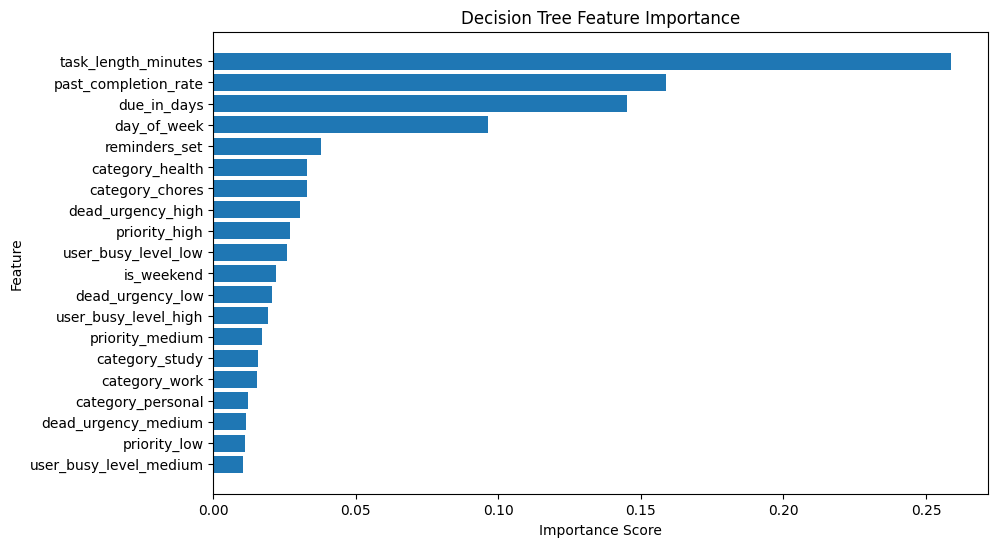

In [92]:
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"]
)
plt.gca().invert_yaxis()
plt.title("Decision Tree Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Random Forest Classifier (no tuning yet)

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train_encoded, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [96]:
# Evaluate on validation set

y_pred_rf = rf_model.predict(X_val_encoded)

rf_accuracy = accuracy_score(y_val, y_pred_rf)

rf_accuracy

0.5925

## Compare models

In [99]:
model_results = pd.DataFrame({
    "model": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "validation_accuracy": [
        logreg_accuracy,
        dt_accuracy,
        rf_accuracy
    ]
})

model_results

,model,validation_accuracy
0,Logistic Regression,0.6575
1,Decision Tree,0.5050
2,Random Forest,0.5925


## Random Forest tuning

In [100]:
depths = [3, 5, 10, None]

rf_results = []

for depth in depths:
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=depth,
        random_state=42
    )
    rf.fit(X_train_encoded, y_train)
    
    y_pred = rf.predict(X_val_encoded)
    acc = accuracy_score(y_val, y_pred)
    
    rf_results.append({
        "max_depth": depth,
        "val_accuracy": acc
    })

pd.DataFrame(rf_results)

,max_depth,val_accuracy
0,3.0,0.6400
1,5.0,0.6250
2,10.0,0.5975
3,NaN,0.6050


## Tune the Decision Tree

In [101]:
# Try a few max_depth values and keep min_samples_leaf at default (1)
depths = [2, 3, 5, 10, None]

dt_results = []

for depth in depths:
    dt = DecisionTreeClassifier(
        max_depth=depth,
        random_state=42
    )
    dt.fit(X_train_encoded, y_train)
    
    y_pred = dt.predict(X_val_encoded)
    acc = accuracy_score(y_val, y_pred)
    
    dt_results.append({
        "max_depth": depth,
        "val_accuracy": acc
    })

dt_results_df = pd.DataFrame(dt_results)
dt_results_df

,max_depth,val_accuracy
0,2.0,0.6550
1,3.0,0.6100
2,5.0,0.5825
3,10.0,0.5100
4,NaN,0.5050


In [102]:
# tune min_samples_leaf for a deeper tree

leaf_sizes = [1, 2, 5, 10]

dt_results_full = []

for depth in [3, 5, 10, None]:
    for leaf in leaf_sizes:
        dt = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_leaf=leaf,
            random_state=42
        )
        dt.fit(X_train_encoded, y_train)
        
        y_pred = dt.predict(X_val_encoded)
        acc = accuracy_score(y_val, y_pred)
        
        dt_results_full.append({
            "max_depth": depth,
            "min_samples_leaf": leaf,
            "val_accuracy": acc
        })

pd.DataFrame(dt_results_full).sort_values(by="val_accuracy", ascending=False)

,max_depth,min_samples_leaf,val_accuracy
0,3.0,1,0.6100
1,3.0,2,0.6100
2,3.0,5,0.6100
3,3.0,10,0.6100
7,5.0,10,0.5925
5,5.0,2,0.5850
6,5.0,5,0.5850
4,5.0,1,0.5825
11,10.0,10,0.5625
15,NaN,10,0.5625


In [6]:
!python train.py

Training done, model saved.


In [2]:
!python predict.py

   task_id  priority  dead_urgency  ...  day_of_week pred_completed  probability
0        1         2             3  ...            2              1     0.735645
1        2         3             2  ...            6              1     0.882301
2        3         1             1  ...            0              0     0.365890

[3 rows x 13 columns]
